#Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE

# Configure visual settings for plots
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize':(10,8)})
print("Libraries imported\n")

Libraries imported



 ## Data Collection and Exploration

Dataset loaded.

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 

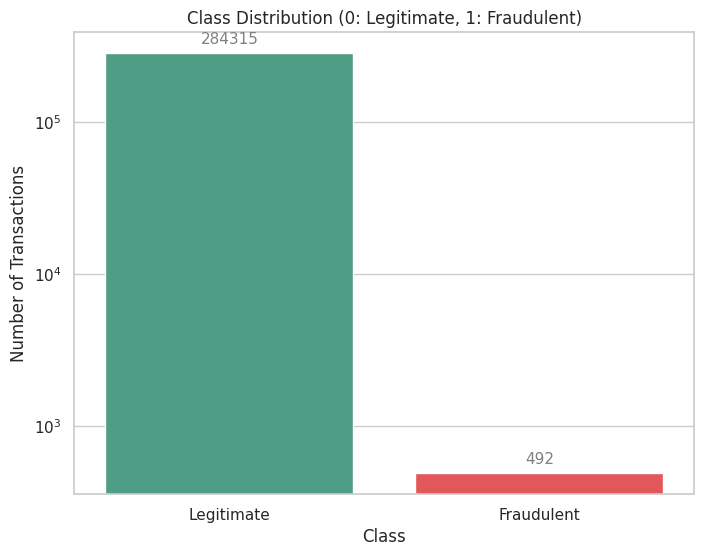



After Exploration, the dataset is highly imbalanced.





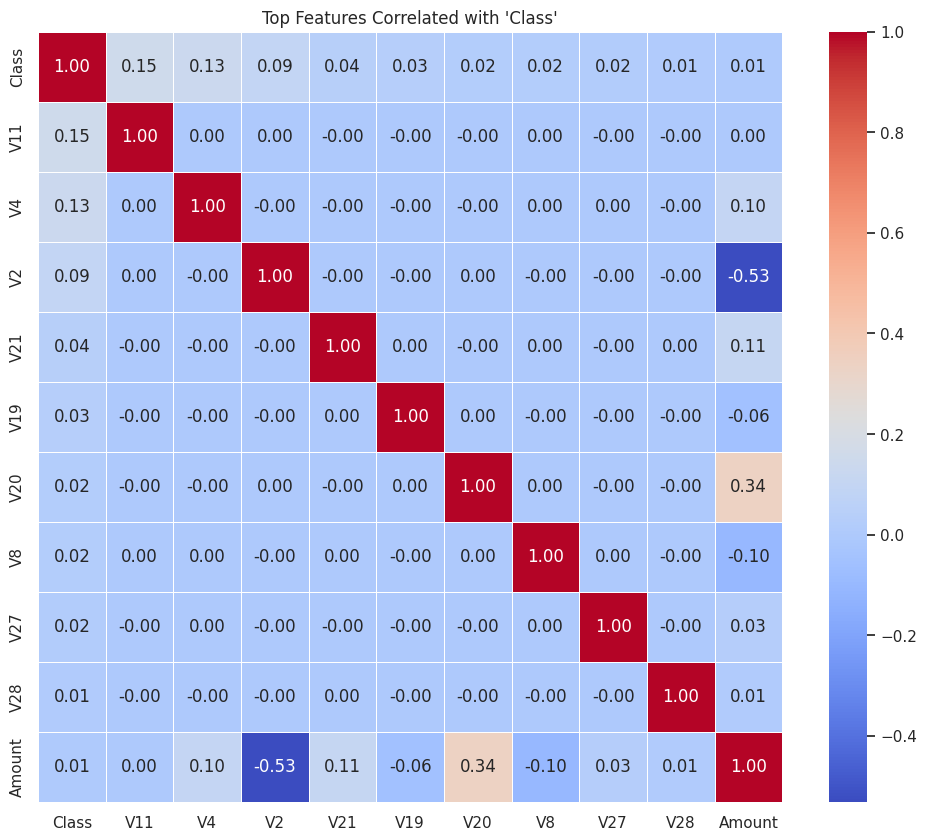


Correlation with Class (target variable):
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


In [6]:
#Load the dataset
file_url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
try:
    df = pd.read_csv(file_url)
    print("Dataset loaded.")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except Exception as e:
    print(f"Error loading data: {e}")

#To perform exploratory data analysis
print("\nDataset Information:")
df.info()
print("\nChecking for missing values:")
# df.isnull().sum().max() == 0 returns True if there are no missing values
print(f"No missing values in dataset: {df.isnull().sum().max() == 0}")
print("\n")

#Distribution of transaction classes
class_counts = df['Class'].value_counts()
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(class_counts)
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
ax=sns.countplot(x='Class', data=df, hue='Class', palette=['#43aa8b', '#f94144'], legend=False)
plt.title('Class Distribution (0: Legitimate, 1: Fraudulent)')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
ax.set_yscale('log')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
plt.show()
print("\n")
print("After Exploration, the dataset is highly imbalanced.")
print("\n\n")

#Correlation Analysis
corr = df.corr()

#Top features most correlated with 'Class
corr_class = corr['Class'].sort_values(ascending=False)
top_corr_features = corr_class.head(11).index

#Create a smaller correlation matrix with only these features
top_corr = df[top_corr_features].corr()

#Visualize the focused correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.title('Top Features Correlated with \'Class\'')
plt.show()


#Display correlations
print("\nCorrelation with Class (target variable):")
print(corr_class)

## Data Pre-processing

In [7]:
#Scale numerical features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', df.pop('scaled_amount'))
df.insert(1, 'scaled_time', df.pop('scaled_time'))
print("\nUpdated DataFrame head:")
print(df.head())

#To handle class imbalance
# First, split the data into training and testing sets.
X = df.drop('Class', axis=1)
y = df['Class']

# Stratify 'y' to ensure the class distribution is maintained in train/test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

#Applying SMOTE (Synthetic Minority Over-sampling Technique) to the training data which isonly done to prevent data leakage.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution in the resampled training data:")
print(pd.Series(y_train_resampled).value_counts())


Updated DataFrame head:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       0.244964    -1.996583 -1.359807 -0.072781  2.536347  1.378155   
1      -0.342475    -1.996583  1.191857  0.266151  0.166480  0.448154   
2       1.160686    -1.996562 -1.358354 -1.340163  1.773209  0.379780   
3       0.140534    -1.996562 -0.966272 -0.185226  1.792993 -0.863291   
4      -0.073403    -1.996541 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27    

##Model Selection and Implementation

In [8]:
#Implement and train the selected algorithms
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

#Train each model on the resampled (balanced) training data
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
print("\nAll models have been trained successfully.")

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...

All models have been trained successfully.


## Model Evaluation


 - Logistic Regression - 
 
Accuracy: 0.9742
Precision: 0.0580
Recall: 0.9184
F1-Score: 0.1092
ROC-AUC: 0.9699

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99     56864
  Fraudulent       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



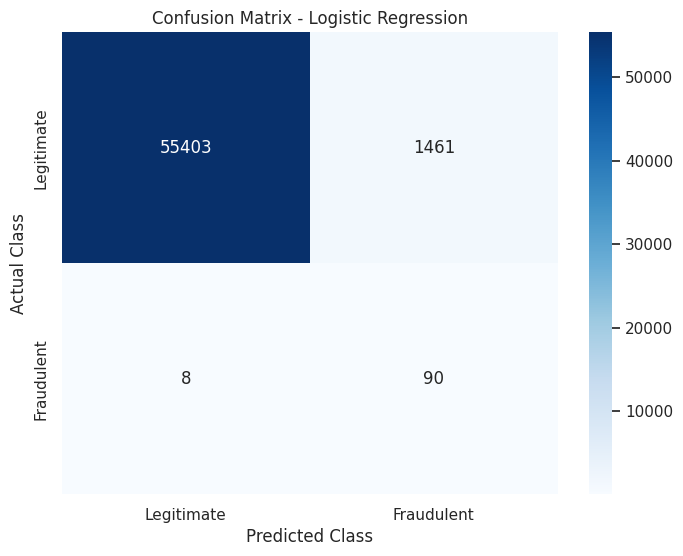




 - Decision Tree - 
 
Accuracy: 0.9970
Precision: 0.3363
Recall: 0.7755
F1-Score: 0.4691
ROC-AUC: 0.8864

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
  Fraudulent       0.34      0.78      0.47        98

    accuracy                           1.00     56962
   macro avg       0.67      0.89      0.73     56962
weighted avg       1.00      1.00      1.00     56962



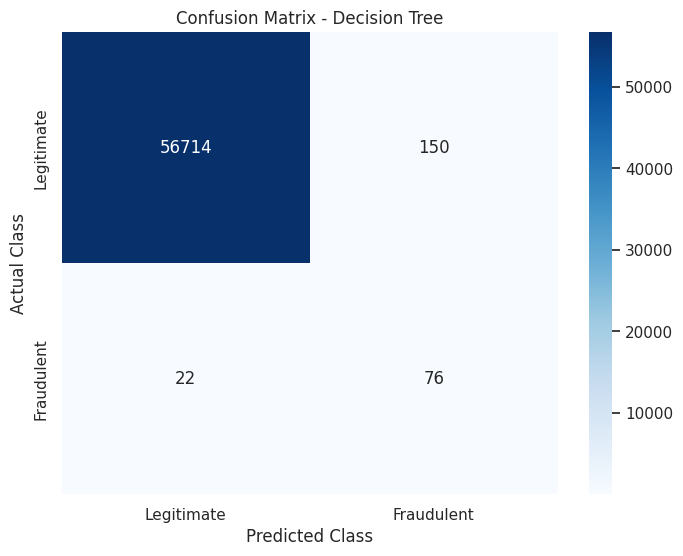




 - Random Forest - 
 
Accuracy: 0.9995
Precision: 0.8602
Recall: 0.8163
F1-Score: 0.8377
ROC-AUC: 0.9791

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
  Fraudulent       0.86      0.82      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



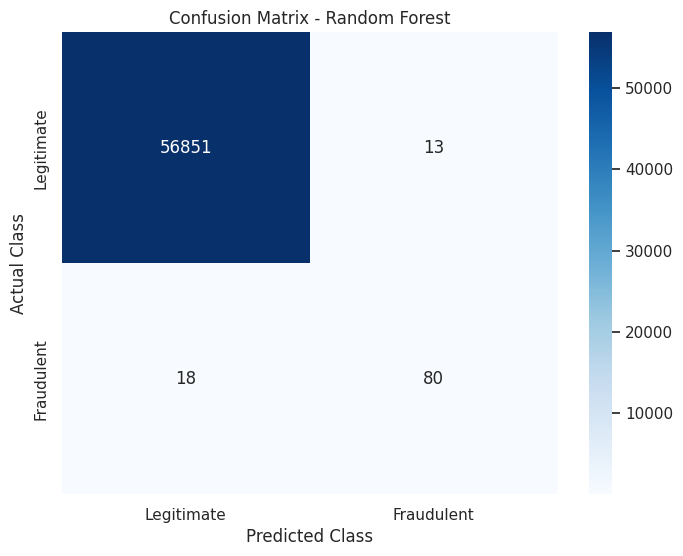




Performance Metrics Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Random Forest        0.999456   0.860215  0.816327  0.837696  0.979111
Decision Tree        0.996980   0.336283  0.775510  0.469136  0.886436
Logistic Regression  0.974211   0.058027  0.918367  0.109157  0.969920




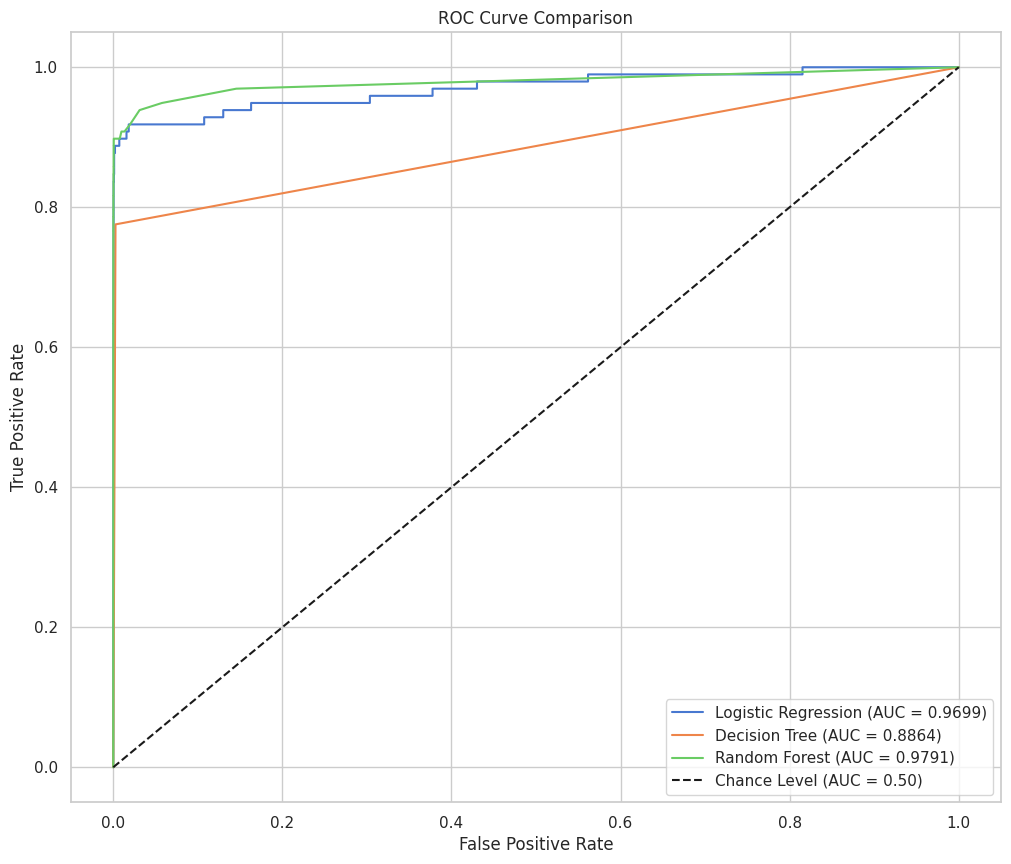

In [9]:
results = {}

#Evaluate performance and create confusion matrices
for name, model in models.items():
    print(f"\n - {name} - \n ")

#Predictions are made on the original and imbalanced test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

#To calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

#To store results for later comparison
    results[name] = {
        "Accuracy": accuracy, "Precision": precision,
        "Recall": recall, "F1-Score": f1, "ROC-AUC": roc_auc
    }

#To display performance metrics and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

#To create and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraudulent'],
                yticklabels=['Legitimate', 'Fraudulent'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    print("\n")

#Compare the models
results_df = pd.DataFrame(results).T
#To sort by F1-score as it provides a good balance between precision and recall,important for imbalanced datasets.
results_df = results_df.sort_values(by="F1-Score", ascending=False)

print("\nPerformance Metrics Comparison:")
print(results_df)
print("\n")

#Plotting the ROC curves for all models
plt.figure(figsize=(12, 10))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = results[name]["ROC-AUC"]
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Final Model Selection

In [10]:
best_model_name = results_df.index[0]
best_model_metrics = results_df.loc[best_model_name]

print(f"The best performing model is: {best_model_name}")
print("\nMetrics for the best model:")
for metric, value in best_model_metrics.items():
    print(f"- {metric}: {value:.4f}")

The best performing model is: Random Forest

Metrics for the best model:
- Accuracy: 0.9995
- Precision: 0.8602
- Recall: 0.8163
- F1-Score: 0.8377
- ROC-AUC: 0.9791
